In [35]:
import torch
from data_utils import GuidedGridMLMDataset, GuidedGridMLM_collate_fn
from torch.utils.data import DataLoader
from GridMLM_tokenizers import GuidedGridMLMTokenizer
from models import GuidedMLMH
from tqdm import tqdm
import numpy as np

In [36]:
device_name = 'cuda:2'
val_dir = '/media/maindisk/data/hooktheory_hr/hooktheory_CA_test'
subfolder = 'CA'
curriculum_type='random'
ablation = 'all'

In [37]:
model_path = 'saved_models/' + subfolder + '/' + curriculum_type + '_' + ablation + '.pt'
tokenizer = GuidedGridMLMTokenizer(fixed_length=256)
val_dataset = GuidedGridMLMDataset(val_dir, tokenizer, 512, frontloading=True)

Loading data file.


In [38]:
if device_name == 'cpu':
        device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device(device_name)
    else:
        print('Selected device not available: ' + device_name)
vae_cfg = {
    'input_dim': 512,
    'hidden_dim': 256,
    'latent_dim': 128,
    'embedding_dim': 64,
    'seq_len': 256,
    'feature_dim': 37,
}
encoder_cfg = {
    'nhead': 8,
    'num_layers': 8,
    'stage_embedding_dim': 64,
    'max_stages': 10
}
model = GuidedMLMH(
    vae_cfg=vae_cfg,
    encoder_cfg=encoder_cfg,
    chord_vocab_size=len(tokenizer.vocab),
    d_model=512,
    conditioning_dim=16,
    pianoroll_dim=100,
    grid_length=256,
    guidance_dim=128,
    unfold_latent=True,
    device=device,
)
checkpoint = torch.load(model_path, map_location=device_name)
model.load_state_dict(checkpoint)
model.eval()
model.to(device)

GuidedMLMH(
  (condition_proj): Linear(in_features=16, out_features=512, bias=True)
  (melody_proj): Linear(in_features=100, out_features=512, bias=True)
  (harmony_embedding): Embedding(354, 512)
  (guidance_to_dmodel): Linear(in_features=128, out_features=512, bias=True)
  (vae): GuidanceVAE(
    (embedding): Embedding(354, 64)
    (encoder_rnn): LSTM(64, 256, batch_first=True)
    (mu_proj): Linear(in_features=256, out_features=128, bias=True)
    (logvar_proj): Linear(in_features=256, out_features=128, bias=True)
    (decoder_rnn): LSTM(128, 256, batch_first=True)
    (recon_proj): Linear(in_features=256, out_features=354, bias=True)
    (feature_proj): Linear(in_features=128, out_features=37, bias=True)
  )
  (encoder): GridMLMMelHarmEncoder(
    (stage_embedding): Embedding(10, 64)
    (stage_proj): Linear(in_features=576, out_features=512, bias=True)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): 

In [39]:
zs = []
for d in tqdm(val_dataset):
    full_harmony = torch.tensor(d['input_ids']).reshape(1, len(d['input_ids']))
    z = model.get_z_from_harmony(full_harmony.to(device)).detach().cpu()[0].tolist()
    zs.append(z)

100%|██████████| 786/786 [00:03<00:00, 260.41it/s]


In [40]:
z_np = np.array( zs )

In [41]:
print(z_np.shape)

(786, 128)


In [42]:
from sklearn.manifold import TSNE

In [49]:
z_tnse = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=2).fit_transform(z_np)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 786 samples in 0.001s...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

[t-SNE] Computed neighbors for 786 samples in 0.375s...
[t-SNE] Computed conditional probabilities for sample 786 / 786
[t-SNE] Mean sigma: 1.708190
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 96.5514297, gradient norm = 0.2179071 (50 iterations in 0.060s)
[t-SNE] Iteration 100: error = 98.5417252, gradient norm = 0.1344533 (50 iterations in 0.064s)
[t-SNE] Iteration 150: error = 96.9113770, gradient norm = 0.3067175 (50 iterations in 0.061s)
[t-SNE] Iteration 200: error = 97.4615250, gradient norm = 0.1875263 (50 iterations in 0.060s)
[t-SNE] Iteration 250: error = 96.9596786, gradient norm = 0.4690431 (50 iterations in 0.063s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.959679
[t-SNE] Iteration 300: error = 2.9491906, gradient norm = 0.0194749 (50 iterations in 0.051s)
[t-SNE] Iteration 350: error = 2.5891893, gradient norm = 0.0152588 (50 iterations in 0.050s)
[t-SNE] Iteration 400: error = 2.4469905, gradient norm = 

In [44]:
print(z_tnse.shape)

(786, 2)


In [45]:
import matplotlib.pyplot as plt

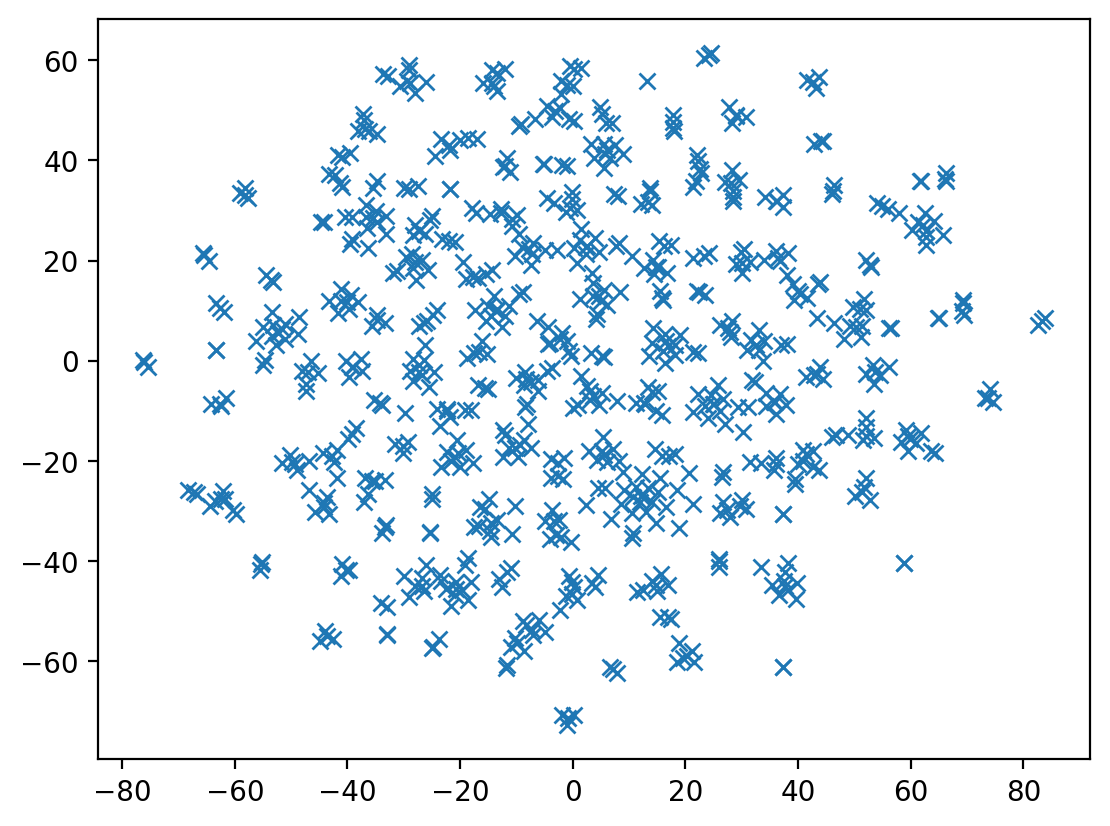

In [50]:
plt.plot(z_tnse[:,0], z_tnse[:,1], 'x')